# Minimum working example to plot the AE waveforms

In this notebook, we demonstrate the AE waveforms of the gouge events.

In [1]:
import os
import obspy
from obspy import read, Stream, Trace
import matplotlib.pyplot as plt
from scipy import signal
%matplotlib inline
import pandas as pd
import numpy as np

plt.rcParams["font.family"] = 'Arial'
# plt.rcParams["font.sans-serif"] = "DejaVu Sans, Arial, Helvetica, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["xtick.major.size"] = 4.75
plt.rcParams["xtick.major.width"] = 0.75
plt.rcParams["xtick.minor.size"] = 3
plt.rcParams["xtick.minor.width"] = 0.4
plt.rcParams["xtick.minor.visible"] = True

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.size"] = 4.75
plt.rcParams["ytick.major.width"] = 0.75
plt.rcParams["ytick.minor.size"] = 3
plt.rcParams["ytick.minor.width"] = 0.4
plt.rcParams["ytick.minor.visible"] = True

plt.rcParams["savefig.transparent"] = True

plt.rcParams['axes.linewidth'] = 0.75

# Read channel data

In [2]:
channel_finame = '../Others/AEchanneltable/AEsensorlocation_onFB03_table.csv'

df_array = pd.read_csv(channel_finame)

channel_loc={}

for i in range(len(df_array)):
    stnm = df_array.iloc[i].Instrument_Label
    xtemp = df_array.iloc[i].North.astype('float')
    ytemp = df_array.iloc[i].East.astype('float')
    ztemp = df_array.iloc[i].Down.astype('float')
    channel_loc[stnm] = [xtemp, ytemp, ztemp]
    
Nsensor = len(channel_loc)
# channel_loc

# 1. Plot raw waveforms 

In [3]:
# load the waveforms
event_id = 72;
datadir = "./data/03_AEobs_waveform/"
st1= read(os.path.join(datadir, f"obs_waveform_event__fb03-087__{event_id:04d}.pickle"), format="PICKLE")

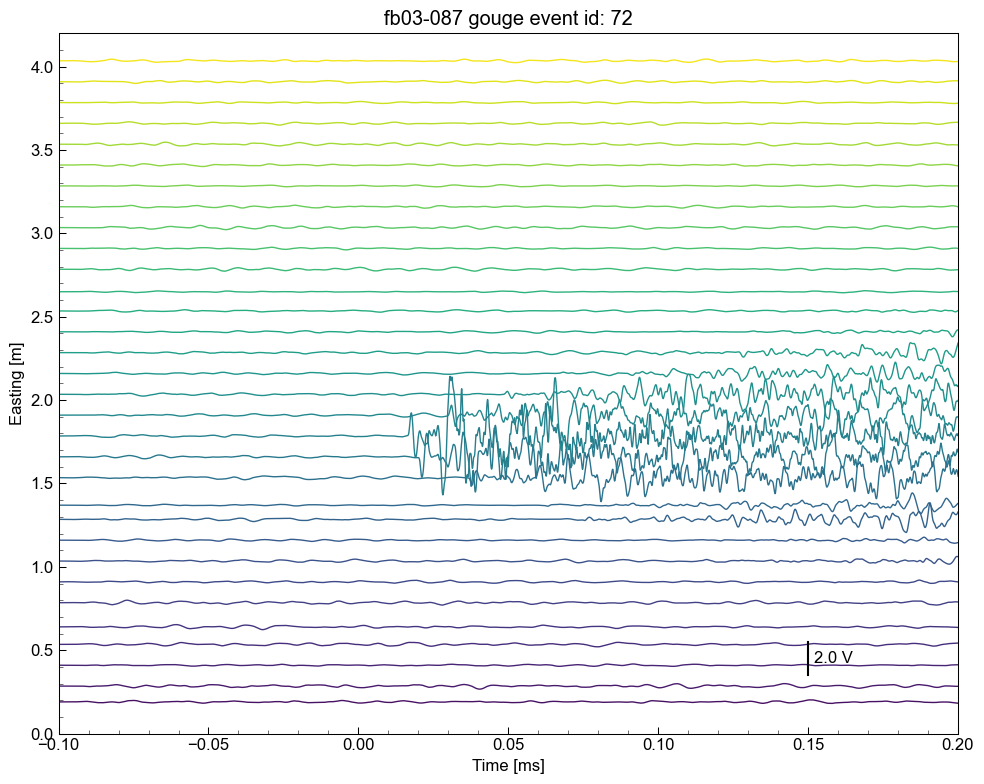

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
tvec = st1[0].times()*1e3
pretrigger = st1.pretrigger*1e3
butterworth_order = 3
freqmin = 0.06e6 # remove low-frequency noise

lc = plt.get_cmap("viridis")
norm = plt.Normalize(0, 4.1)

for i, tr_obs in enumerate(st1):
    
    stnm = tr_obs.stats.station
    sensorloc = channel_loc[stnm]
    sensorloc_x = sensorloc[0]/1e3
        
    # Apply high-pass filter
    # using sos to minimize the numerical error of filter
    sos = signal.butter(butterworth_order, freqmin, 'highpass', fs=tr_obs.stats.sampling_rate, output='sos')
    tr_obs_filtered = tr_obs.copy().taper(0.05)
    tr_obs_filtered.data = signal.sosfilt(sos, tr_obs_filtered.data)

    ampnorm = 10
    
    ax.plot(tvec-pretrigger, tr_obs_filtered.data/ampnorm + sensorloc_x, "-", lw=1, c=lc(norm(sensorloc_x)), zorder=2 )

# annotate the scale of voltage
scale_x = 0.15
scale_y = 0.45
scale_amplitude = 2.0 #[V]
ax.plot([scale_x, scale_x], np.array([-scale_amplitude/2, +scale_amplitude/2])/ampnorm+scale_y, "k-");
ax.text(scale_x+0.002, scale_y, f"{scale_amplitude:.1f} V", va="center")

# decoration of figure
ax.set_xlim([-0.1, 0.2])
ax.set_ylim([0, 4.2])
# ax.set_ylim([1.0, 2.4])

ax.set_xlabel("Time [ms]")
ax.set_ylabel("Easting [m]")
ax.set_title(f"{st1.runID} gouge event id: {event_id:g}")
fig.tight_layout()